In [1]:
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
%matplotlib inline
import os
#from tensorflow import keras
#import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
from keras import metrics
from keras.callbacks import EarlyStopping, History, ModelCheckpoint
from keras.layers.core import Flatten, Dense, Dropout, Reshape, Lambda
from tensorflow.keras.layers import BatchNormalization

In [3]:
#dimensions for the images
img_width,img_height= 150,150

#directories with images
train_data_dir='data/train'
validation_data_dir='data/validation'


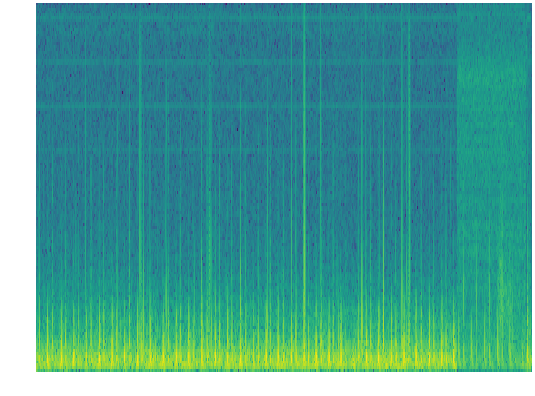

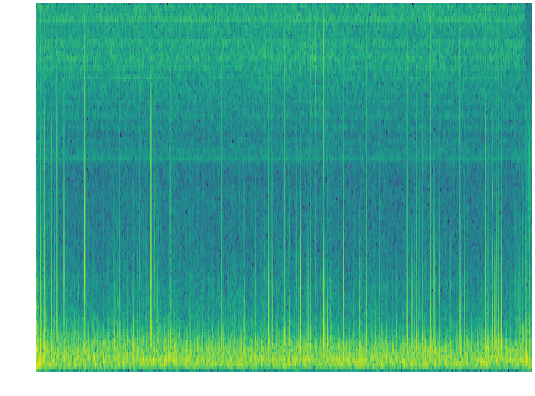

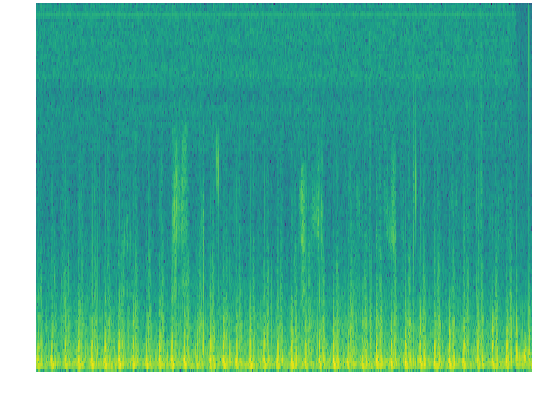

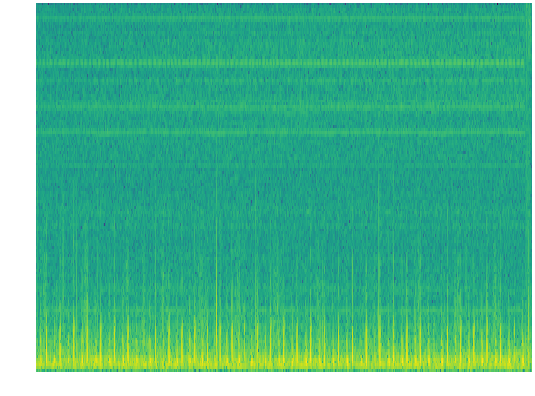

In [4]:
from IPython.display import Image
from IPython.display import display

listOfImageNames = ['data/train/normal/a0408.png',
                    'data/validation/normal/a0009.png',
                   'data/train/abnormal/a0117.png',
                   'data/validation/abnormal/a0001.png']


for imageName in listOfImageNames:
    display(Image(filename=imageName))

In [5]:
#Counting number of images in training and validation set

In [6]:
nor_train_dir = 'data/train/normal/'
nor_valid_dir = 'data/validation/normal/'
abnor_train_dir = 'data/train/abnormal/'
abnor_valid_dir = 'data/validation/abnormal/'

nor_train = len(next(os.walk(nor_train_dir))[2])
nor_valid = len(next(os.walk(nor_valid_dir))[2])
abnor_train = len(next(os.walk(abnor_train_dir))[2])
abnor_valid = len(next(os.walk(abnor_valid_dir))[2])

## We subtract 1 since every directory has a hidden file .DS_Store
print ('Number of samples in training set (normal): {}'.format((nor_train)-1))
print ('Number of samples in validation set (normal): {}'.format((nor_valid)-1))
print ('Number of samples in training set (abnormal): {}'.format((abnor_train)-1))
print ('Number of samples in validation set (abnormal): {}'.format((abnor_valid)-1))

Number of samples in training set (normal): 599
Number of samples in validation set (normal): 142
Number of samples in training set (abnormal): 399
Number of samples in validation set (abnormal): 81


In [7]:
#Visualising the samples using matplotlib

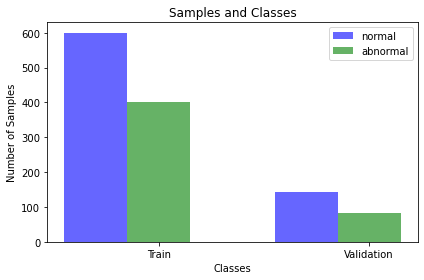

In [8]:
n_groups = 2
train_samples = (nor_train, nor_valid)
validation_samples = (abnor_train, abnor_valid)
 
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.3
opacity = 0.6
 
rects1 = plt.bar(index, train_samples, bar_width,
                 alpha=opacity,
                 color='b',
                 label='normal')
 
rects2 = plt.bar(index + bar_width, validation_samples, bar_width,
                 alpha=opacity,
                 color='g',
                 label='abnormal')
 
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Samples and Classes')
plt.xticks(index + bar_width, ('Train', 'Validation'))
plt.legend()
 
plt.tight_layout()
plt.show()

In [10]:
#Data augmentation

In [11]:
train_datagen= ImageDataGenerator(
        rescale=1./255,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True
        )

test_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
# automagically retrieve images and their classes for train and validation sets
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='binary')

Found 1000 images belonging to 2 classes.
Found 225 images belonging to 2 classes.


In [13]:
#Evaluation

In [14]:
import keras.backend as K

def accuracy(y_true,y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return accuracy

    

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fbeta_score(y_true, y_pred, beta=1):
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')

    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

In [15]:
#Visualisation

In [16]:
import matplotlib.pyplot as plt
def results(history):
    # Accuracy
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['acc']); plt.plot(history.history['val_acc']);
    plt.title('model accuracy'); plt.ylabel('accuracy');
    plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss']); plt.plot(history.history['val_loss']);
    plt.title('model loss'); plt.ylabel('loss');
    plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');
    plt.show()

In [17]:
#Model Implementation

In [18]:
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(img_width,img_height,3)))
model.add(Convolution2D(64, 3, 3))
model.add(BatchNormalization())          
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2),padding='same',data_format='channels_first' ,strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, 3, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2),padding='same',data_format='channels_first',strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, 3, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2),padding='same',data_format='channels_first',strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2),padding='same',data_format='channels_first',strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2),padding='same',data_format='channels_first',strides=(2,2)))

model.add(Flatten())
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))          
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(BatchNormalization())
model.add(Activation('sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.


In [19]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy',precision,recall,fbeta_score])

In [20]:
nb_epoch = 10
nb_train_samples = 1000
nb_validation_samples = 225

In [21]:
history = model.fit_generator(
train_generator,
steps_per_epoch=nb_train_samples,
epochs=nb_epoch,
validation_data=validation_generator,
validation_steps=nb_validation_samples)

/var/folders/dz/tvcs2gh939j519q07st8j37m0000gn/T/ipykernel_15365/3597687952.py:1: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(
2022-05-12 21:23:08.225770: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-12 21:23:08.226556: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-05-12 21:23:08.277940: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-12 21:23:08.279477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plug

Metal device set to: Apple M1
Epoch 1/10


2022-05-12 21:23:09.029434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-12 21:23:09.046068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-12 21:23:09.057741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-12 21:23:09.069366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-12 21:23:09.361953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-12 21:23:09.394492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-12 21:23:09.430006: I tensorflow/core/grappler/optimizers/cust

1000/1000 [==============================] - ETA: 0s - batch: 499.5000 - size: 31.2560 - loss: 0.4763 - acc: 0.7867 - precision: 0.7823 - recall: 0.8922 - fbeta_score: 0.8288

/Users/raghuramdaita/env/lib/python3.8/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2022-05-12 21:27:13.256710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1000/1000 [==============================] - 265s 258ms/step - batch: 499.5000 - size: 31.2560 - loss: 0.4763 - acc: 0.7867 - precision: 0.7823 - recall: 0.8922 - fbeta_score: 0.8288 - val_loss: 2.9651 - val_acc: 0.3645 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 2/10
1000/1000 [==============================] - 260s 261ms/step - batch: 499.5000 - size: 31.2320 - loss: 0.3678 - acc: 0.8445 - precision: 0.8398 - recall: 0.9190 - fbeta_score: 0.8740 - val_loss: 1.4612 - val_acc: 0.3869 - val_precision: 0.5033 - val_recall: 0.0581 - val_fbeta_score: 0.0966
Epoch 3/10
1000/1000 [==============================] - 259s 259ms/step - batch: 499.5000 - size: 31.2560 - loss: 0.2938 - acc: 0.8794 - precision: 0.8779 - recall: 0.9297 - fbeta_score: 0.8996 - val_loss: 2.0141 - val_acc: 0.4082 - val_precision: 0.7080 - val_recall: 0.0761 - val_fbeta_score: 0.1291
Epoch 4/10
1000/1000 [==============================] - 263s 263ms/step - batch: 499.5000 - s

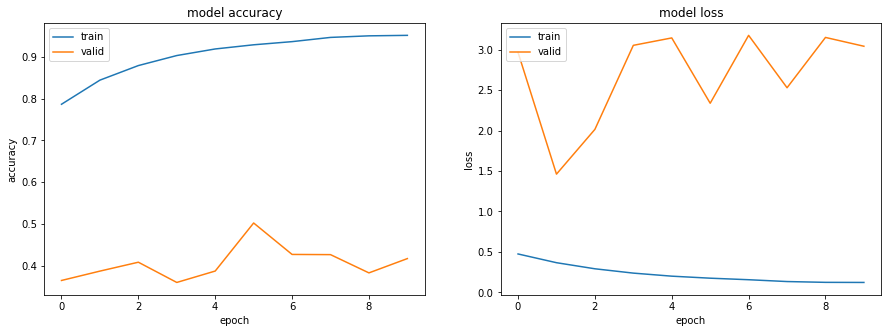

In [25]:
results(history)

In [45]:
#Transfer Learning and using pre-trained models
#VGG16 model 

In [46]:
#Processing the batches for VGG16 model

In [40]:
train_generator_bottleneck = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode=None,
        shuffle=False)

validation_generator_bottleneck = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode=None,
        shuffle=False)

Found 1000 images belonging to 2 classes.
Found 225 images belonging to 2 classes.


In [82]:
#def VGG_16():
model_vgg = Sequential()
model_vgg.add(ZeroPadding2D((1, 1), input_shape=(img_width, img_height, 3)))

model_vgg.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
model_vgg.add(ZeroPadding2D((1, 1)))
model_vgg.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
model_vgg.add(MaxPooling2D((2, 2),padding='same',data_format='channels_first',strides=(2, 2)))

model_vgg.add(ZeroPadding2D((1, 1)))
model_vgg.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
model_vgg.add(ZeroPadding2D((1, 1)))
model_vgg.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_2'))
model_vgg.add(MaxPooling2D((2, 2),padding='same',data_format='channels_first',strides=(2, 2)))

model_vgg.add(ZeroPadding2D((1, 1)))
model_vgg.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_1'))
model_vgg.add(ZeroPadding2D((1, 1)))
model_vgg.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2'))
model_vgg.add(ZeroPadding2D((1, 1)))
model_vgg.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_3'))
model_vgg.add(MaxPooling2D((2, 2),padding='same',data_format='channels_first',strides=(2, 2)))

model_vgg.add(ZeroPadding2D((1, 1)))
model_vgg.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_1'))
model_vgg.add(ZeroPadding2D((1, 1)))
model_vgg.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_2'))
model_vgg.add(ZeroPadding2D((1, 1)))
model_vgg.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_3'))
model_vgg.add(MaxPooling2D((2, 2),padding='same',data_format='channels_first',strides=(2, 2)))

model_vgg.add(ZeroPadding2D((1, 1)))
model_vgg.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1'))
model_vgg.add(ZeroPadding2D((1, 1)))
model_vgg.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_2'))
model_vgg.add(ZeroPadding2D((1, 1)))
model_vgg.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_3'))
model_vgg.add(MaxPooling2D((2, 2),padding='same',data_format='channels_first',strides=(2, 2)))
    
model_vgg.add(Flatten())
model_vgg.add(Dense(4096, activation='relu'))
model_vgg.add(Dropout(0.5))
model_vgg.add(Dense(4096, activation='relu'))
model_vgg.add(Dropout(0.5))
model_vgg.add(Dense(1, activation='sigmoid'))

    
#    return model

In [84]:
#model=VGG_16()

model_vgg.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy',precision,recall,fbeta_score])

In [85]:
nb_epoch = 10
nb_train_samples = 1000
nb_validation_samples = 225

In [87]:
history = model_vgg.fit_generator(train_generator,
steps_per_epoch=nb_train_samples,
epochs=nb_epoch,
validation_data=validation_generator,
validation_steps=nb_validation_samples) 

/var/folders/dz/tvcs2gh939j519q07st8j37m0000gn/T/ipykernel_15365/439960398.py:1: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_vgg.fit_generator(train_generator,
2022-05-12 23:13:11.773301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-12 23:13:12.020695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-12 23:13:13.799552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-12 23:13:13.916764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/10


2022-05-12 23:13:14.021510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-12 23:13:14.138501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-12 23:13:14.580640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-12 23:13:14.730669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-12 23:13:14.916604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1000/1000 [==============================] - ETA: 0s - batch: 499.5000 - size: 31.2560 - loss: 0.6751 - acc: 0.5994 - precision: 0.5997 - recall: 0.9990 - fbeta_score: 0.7448

2022-05-12 23:17:28.945898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1000/1000 [==============================] - 278s 275ms/step - batch: 499.5000 - size: 31.2560 - loss: 0.6751 - acc: 0.5994 - precision: 0.5997 - recall: 0.9990 - fbeta_score: 0.7448 - val_loss: 0.6679 - val_acc: 0.6353 - val_precision: 0.6147 - val_recall: 0.9333 - val_fbeta_score: 0.7359
Epoch 2/10
1000/1000 [==============================] - 265s 265ms/step - batch: 499.5000 - size: 31.2320 - loss: 0.6739 - acc: 0.6007 - precision: 0.6003 - recall: 1.0000 - fbeta_score: 0.7461 - val_loss: 0.6596 - val_acc: 0.6353 - val_precision: 0.6363 - val_recall: 0.9556 - val_fbeta_score: 0.7576
Epoch 3/10
1000/1000 [==============================] - 269s 269ms/step - batch: 499.5000 - size: 31.2800 - loss: 0.6740 - acc: 0.5992 - precision: 0.5986 - recall: 1.0000 - fbeta_score: 0.7453 - val_loss: 0.6608 - val_acc: 0.6352 - val_precision: 0.6361 - val_recall: 0.9556 - val_fbeta_score: 0.7576
Epoch 4/10
1000/1000 [==============================] - 270s 270ms/step - batch: 499.5000 - size: 31.2320

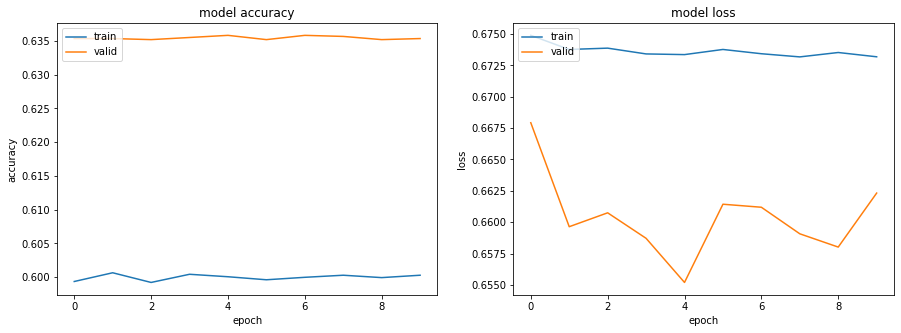

In [88]:
results(history)